# Genetic Algorithm to solve the D-EVRP-NL
This notebook allows you to work with the implemented library and solve the Dynamic Electric Vehicle Routing Problem with Non-linear charging functions. The main purpose is to give good visualization of the solution and easy handling of network complexity.

## Initialization

First, import required libraries.

In [1]:
# Too work with arguments and script paths
import sys

# scientific libraries and tutilities
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt

# setup pyplot
conf = {'font.size': 20}
plt.rcParams.update(conf)

# GA library
from deap import base
from deap import creator
from deap import tools

# Visualization tools
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot, column
from bokeh.layouts import row as layout_row
from bokeh.models.annotations import Arrow, Label
from bokeh.models.arrow_heads import OpenHead, NormalHead, VeeHead
from bokeh.models import ColumnDataSource, Div, Whisker, Span, Range1d
from bokeh.io import export_svgs, export_png

# Simulation environment tools
sys.path.append('..')
import res.EV_utilities
import res.GA_utilities_1

# Display useful loading of bokeh library and start timer
output_notebook()
t0 = time.time()

Loading BokehJS ...

The following are user-defined variables

In [2]:
# Network size and where are data files stored
networkSize = 30
folderPath = '../data/GA_implementation/'

# Charging stations points
chargingTimePoints = True
timePoints = [0.0, 40.0, 60., 120.]
socPoints = [0.0, 75.0, 90.0, 100.0]

# figure related
FIGURE_WIDTH = 800
FIGURE_HEIGHT = 500

figureFolderPath = "../data/GA_implementation/"+str(networkSize)+"network/"

The following implements some utility functions, not related to main GA

In [3]:
# %% Utilities
def shapeItems(items, shape=(None, 2)):
    numOfItems = len(items)
    columns = shape[1]

    if shape[0] is None:
        rows = int(numOfItems / columns) + int(numOfItems % columns)
    else:
        rows = shape[0]

    gridList = [[None] * columns for _ in range(0, rows)]

    i = 0
    j = 0
    for fig in items:
        if j == columns:
            i += 1
            j = 0
        gridList[i][j] = fig
        j += 1
    return gridList

## Import data
There are three main data files:
    - Time matrix: containing the time it takes to travel along arcs between each node
    - Energy matrix: cantaining the energy it takes to travel along arcs between each node
    - Info file: containing the information of each node

In [4]:
# %% Import time and energy matrices and show a value example

pathTM = folderPath + 'timeMatrix_' + str(networkSize) + 'nodes.csv'
timeMatrix = pd.read_csv(pathTM).set_index("TT(MIN)")

print('Time matrix:\n', timeMatrix, "\n")

pathEM = folderPath + 'energyMatrix_' + str(networkSize) + 'nodes.csv'
energyMatrix = pd.read_csv(pathEM).set_index("ENERGY(AH)")

print('Energy matrix:\n', energyMatrix, '\n')

# Indexing example
print("An index example...")
t = timeMatrix.iat[1, 2]
print("Travel time from 1 to 2: ", t)

e = energyMatrix.iat[1, 2]
print("Energy consumption from 1 to 2: ", e, '\n')


Time matrix:
                  0          1          2          3          4          5  \
TT(MIN)                                                                     
0         0.000000  19.461347  18.978988  13.148921   9.717353  12.218160   
1        16.493709   0.000000  12.248480  18.882980   8.871050  19.760969   
2         8.749181   9.510101   0.000000   9.718716   8.723837  10.651628   
3        15.071604  19.956029   8.004054   0.000000   8.328253  15.761568   
4        18.321813  14.079354  11.400399  13.441945   0.000000  10.188385   
5        13.129251  14.277677  12.934420  17.542826  10.400436   0.000000   
6        16.718770  15.227973  17.584267  17.581704  11.740838  14.485349   
7         9.773022  18.981200  19.692553  16.201921  18.986956  13.244679   
8        15.595551  10.394889  11.511726  19.491460  13.725072  18.932637   
9        12.956503  15.065482   8.913761   8.955467  10.597430  19.375507   
10       15.091891  10.984494  16.901587  13.808664  15.051596

In [5]:
# %% Import nodes information to differentiate among them

infoMatrix = pd.read_csv(folderPath + 'infoMatrix_' + str(networkSize) + 'nodes.csv')

depotDF = infoMatrix[infoMatrix['TYPE'] == 'DEPOT'].dropna(axis=1)
customerDF = infoMatrix[infoMatrix['TYPE'] == 'CUSTOMER'].dropna(axis=1)
csDF = infoMatrix[infoMatrix['TYPE'] == 'CS'].dropna(axis=1)

print('Depots DF:\n', depotDF, '\n')
print('Customers DF:\n', customerDF, '\n')
print('Charge Stations DF\n', csDF, '\n')


Depots DF:
    ID  POS_X  POS_Y   TYPE
0   0    0.0    0.0  DEPOT 

Customers DF:
     ID    DEMAND       POS_X       POS_Y  SERVICE_TIME  TIME_WINDOW_LOW  \
1    1  0.193070    2.900621 -115.774200      9.126911       642.166928   
2    2  0.197672  -90.875017 -103.370371      2.651879       630.665622   
3    3  0.438245   46.516821   20.163101      5.557819       735.303201   
4    4  0.374963   -4.359159   41.650064      7.049608       818.580036   
5    5  0.131632  -87.095251  128.085678      8.125989       913.992573   
6    6  0.272627  -52.455049   70.151008      5.738071       844.952962   
7    7  0.320439   78.247857   55.963501      7.154479       928.146763   
8    8  0.105744   70.829963  102.637077      7.249441       835.056700   
9    9  0.255904   75.751425  142.944511      1.862994       722.042194   
10  10  0.433611  107.073285  -78.703290      1.196350       731.541761   
11  11  0.169499   19.786420  100.184969      5.157274       658.263866   
12  12  0.258370 

## Create variables

In [6]:
# Create list with information

networkDict = {'DEPOT_LIST': [], 'CUSTOMER_LIST': [], 'CS_LIST': [],
               'TIME_MATRIX': timeMatrix, 'ENERGY_MATRIX': energyMatrix}

for _, row in depotDF.iterrows():
    networkDict[row['ID']] = res.EV_utilities.DepotNode(row['ID'])
    networkDict['DEPOT_LIST'].append(networkDict[row['ID']])

for _, row in customerDF.iterrows():
    networkDict[row['ID']] = res.EV_utilities.CustomerNode(row['ID'], row['SERVICE_TIME'], row['DEMAND'],
                                                           timeWindowUp=row['TIME_WINDOW_UP'],
                                                           timeWindowDown=row['TIME_WINDOW_LOW'])
    networkDict['CUSTOMER_LIST'].append(networkDict[row['ID']])

figureList = []

for _, row in csDF.iterrows():
    # Simple CS with linear curve
    if chargingTimePoints:
        networkDict[row['ID']] = res.EV_utilities.ChargeStationNode(row['ID'],
                                                                    timePoints=timePoints,
                                                                    socPoints=socPoints)
    else:
        networkDict[row['ID']] = res.EV_utilities.ChargeStationNode(row['ID'])

    networkDict['CS_LIST'].append(networkDict[row['ID']])
    # Append to show as grid
    s = figure(width=400, height=250, title='Charging function of CS ' + str(networkDict[row['ID']].id))

    s.xaxis.axis_label = 'Time (min)'
    s.yaxis.axis_label = 'SOC (%)'
    s.line(networkDict[row['ID']].timePoints, networkDict[row['ID']].socPoints, color='black', line_width=2)
    s.asterisk(networkDict[row['ID']].timePoints, networkDict[row['ID']].socPoints, color='black', size=10)
    
    # Save
    s.output_backend = "svg"
    export_svgs(s, filename=figureFolderPath+"CS"+str(row['ID'])+"_chargingFunction.svg")
    
    figureList.append(s)

# show grid
shapedFigs = shapeItems(figureList, shape=(None, 2))
p = gridplot(shapedFigs, toolbar_location='left')
show(p)


## Assign customers to each EV

In [7]:
# %% Number of cars and their random set to visit. Ensure that each one of them visit at least one

t1 = time.time()

nVehicles = 2
chooseCustomersRandom = False

vehiclesDict = {}

if chooseCustomersRandom:
    # Choose the customers each vehicle will visit randomly
    customersID = [evID for evID in customerDF['ID']]
    nCustomers = len(customersID)
    nCustomersPerCar = [int(nCustomers / nVehicles)] * nVehicles

    if len(customersID) % nVehicles != 0:
        nCustomersPerCar[-1] = int(len(customersID) / nVehicles) + 1

    for i, j in enumerate(nCustomersPerCar):
        print('Car', i, 'must visit', j, 'customer/s')
    print('\n')

    for carId, nCustomersCar in enumerate(nCustomersPerCar):
        carCustomersId = []
        for j in range(0, nCustomersCar):
            index = random.randint(0, len(customersID) - 1)
            carCustomersId.append(customersID.pop(index))
        customersToVisit = [customerId for customerId in carCustomersId]
        print('Car', carId, 'must visit customers with ID:', customersToVisit)

        nodeSequence = [0] + customersToVisit + [0]
        chargingSequence = [0] * len(nodeSequence)

        # instantiate
        Qi = 80.0
        x1 = 24.0 * 30.0
        sumDi = np.sum([networkDict[i].demand for i in nodeSequence])
        vehiclesDict[carId] = res.EV_utilities.ElectricVehicle(carId, customersToVisit, networkDict,
                                                               nodeSequence=nodeSequence,
                                                               chargingSequence=chargingSequence,
                                                               timeMatrix=timeMatrix.iat,
                                                               energyMatrix=energyMatrix.iat,
                                                               x1=x1, x2=Qi, x3=sumDi)
else:
    customersID = [[14, 26, 9, 3, 11, 20, 6, 21, 16, 29, 4,7, 17, 25],
                   [1, 2, 8, 10, 22, 5, 19, 28, 27, 18, 13, 12, 23]]
    for i, l in enumerate(customersID):
        print('Car',i,'must visit', len(l),'customers')

    nCustomers = sum([len(x) for x in customersID])

    for carId, customersToVisit in enumerate(customersID):
        print('Car', carId, 'must visit customers with ID:', customersToVisit)

        # IMPORTANT: the proposed nodeSequence
        nodeSequence = [0] + customersToVisit + [0]
        chargingSequence = [0] * len(nodeSequence)

        # instantiate
        Qi = 80.0
        sumDi = np.sum([networkDict[i].demand for i in nodeSequence])
        vehiclesDict[carId] = res.EV_utilities.ElectricVehicle(carId, customersToVisit, networkDict,
                                                               nodeSequence=nodeSequence,
                                                               chargingSequence=chargingSequence,
                                                               timeMatrix=timeMatrix.iat,
                                                               energyMatrix=energyMatrix.iat,
                                                               x2=Qi, x3=sumDi)


Car 0 must visit 14 customers
Car 1 must visit 13 customers
Car 0 must visit customers with ID: [14, 26, 9, 3, 11, 20, 6, 21, 16, 29, 4, 7, 17, 25]
Car 1 must visit customers with ID: [1, 2, 8, 10, 22, 5, 19, 28, 27, 18, 13, 12, 23]


 ## Setup GA

In [8]:
# %% Genetic algorithm

# allowed charging operations
numChargeOp = 2

# Build toolbox and useful classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Individual initializer
toolbox.register("individual", res.GA_utilities_1.createRandomIndividual, vehiclesDict,
                 allowed_charging_operations=numChargeOp)

# Fitness, crossover, mutation and selection
toolbox.register("evaluate", res.GA_utilities_1.fitness, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("mate", res.GA_utilities_1.crossover, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("mutate", res.GA_utilities_1.mutate, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("select", tools.selTournament, tournsize=3)

# Useful to decode
toolbox.register("decode", res.GA_utilities_1.decodeFunction, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)

# Constraint handling
toolbox.register("distance", res.GA_utilities_1.distanceToFeasibleZone, vehicleDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("feasible", res.GA_utilities_1.feasibleIndividual, vehicleDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.decorate("evaluate", tools.DeltaPenality(toolbox.feasible, -500000.0, toolbox.distance))

## Run GA

In [9]:
# %% the algorithm

tInitGA = time.time()
# Population TODO create function
n = 100
generations = 170

pop = []
for i in range(0, n):
    pop.append(creator.Individual(toolbox.individual()))

# CXPB  is the probability with which two individuals
#       are crossed
#
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = 0.4, 0.4

print("################  Start of evolution  ################")

# Evaluate the entire population
# fitnesses = list(map(toolbox.evaluate, pop))

for ind in pop:
    fit = toolbox.evaluate(ind)
    ind.fitness.values = fit

print("  Evaluated %i individuals" % len(pop))

# Extracting all the fitnesses of
fits = [ind.fitness.values[0] for ind in pop]

# Variable keeping track of the number of generations
g = 0
Ymax = []
Ymin = []
Yavg = []
Ystd = []
X = []

bestOfAll = tools.selBest(pop, 1)[0]

# Begin the evolution
while g < generations:
    # A new generation
    g = g + 1
    X.append(g)
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):

        # cross two individuals with probability CXPB
        if random.random() < CXPB:
            toolbox.mate(child1, child2)

            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:

        # mutate an individual with probability MUTPB
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_ind:
        fit = toolbox.evaluate(ind)
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(invalid_ind))

    # The population is entirely replaced by the offspring
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

    Ymax.append(-max(fits))
    Ymin.append(-min(fits))
    Yavg.append(mean)
    Ystd.append(std)

    bestInd = tools.selBest(pop, 1)[0]
    print("Best individual: ", bestInd)

    worstInd = tools.selWorst(pop, 1)[0]
    print("Worst individual: ", worstInd)

    # Save best ind
    if bestInd.fitness.values[0] > bestOfAll.fitness.values[0]:
        bestOfAll = bestInd

# %%
print("################  End of (successful) evolution  ################")


################  Start of evolution  ################
  Evaluated 100 individuals
-- Generation 1 --
  Evaluated 59 individuals
  Min -7047669.737159815
  Max -758892.8698546545
  Avg -2450911.142412203
  Std 1341622.444095182
Best individual:  [9, 11, 20, 6, 7, 4, 21, 25, 17, 26, 3, 29, 14, 16, -1, 0, 10.0, -1, 0, 10.0, 653, 22, 10, 5, 23, 8, 13, 1, 2, 19, 28, 18, 12, 27, -1, 0, 10.0, -1, 0, 10.0, 654]
Worst individual:  [11, 4, 21, 29, 7, 17, 25, 9, 20, 26, 3, 14, 16, 6, -1, 0, 10.0, -1, 0, 10.0, 210, 5, 13, 2, 19, 23, 12, 1, 18, 10, 22, 8, 27, 28, -1, 0, 10.0, -1, 0, 10.0, 142]
-- Generation 2 --
  Evaluated 55 individuals
  Min -3786262.2979559004
  Max -729997.8933234753
  Avg -1498014.8447692408
  Std 610397.935870537
Best individual:  [9, 11, 20, 6, 7, 4, 21, 25, 14, 26, 3, 29, 17, 16, -1, 0, 10.0, -1, 0, 10.0, 653, 22, 10, 5, 23, 8, 13, 1, 2, 19, 28, 18, 12, 27, -1, 0, 10.0, -1, 0, 10.0, 654]
Worst individual:  [25, 20, 3, 29, 26, 9, 4, 7, 21, 6, 16, 11, 14, 17, -1, 0, 10.0, -

  Evaluated 65 individuals
  Min -642246.6605282843
  Max -538758.2771530646
  Avg -573266.2936644686
  Std 20023.931015272257
Best individual:  [9, 29, 3, 11, 14, 26, 20, 25, 4, 6, 17, 21, 7, 16, -1, 0, 10.0, 7, 15, 52.587487077391856, 676, 22, 10, 2, 18, 1, 13, 8, 5, 19, 28, 23, 12, 27, -1, 0, 10.0, -1, 0, 10.0, 714.8727550261499]
Worst individual:  [26, 29, 11, 6, 21, 14, 4, 20, 9, 3, 16, 17, 7, 25, -1, 0, 10.0, -1, 0, 10.0, 653, 22, 10, 2, 12, 8, 13, 1, 5, 19, 28, 23, 18, 27, -1, 0, 10.0, 1, 15, 55.12188255628626, 654]
-- Generation 18 --
  Evaluated 57 individuals
  Min -631423.5628573524
  Max -538882.6589567213
  Avg -560883.0121422111
  Std 17288.53672132667
Best individual:  [9, 29, 3, 11, 14, 26, 20, 25, 4, 6, 17, 21, 7, 16, -1, 0, 10.0, -1, 15, 11.004470118015893, 676, 10, 18, 2, 13, 8, 22, 1, 27, 19, 5, 23, 12, 28, -1, 0, 10.0, -1, 0, 10.0, 687.8216053941314]
Worst individual:  [7, 29, 3, 14, 21, 26, 20, 25, 4, 6, 11, 17, 9, 16, 16, 24, 61.474097957869674, -1, 15, 70.466938

  Evaluated 69 individuals
  Min -594886.322924664
  Max -512443.9271630512
  Avg -525458.1880725144
  Std 16183.713504069432
Best individual:  [9, 11, 14, 26, 3, 25, 20, 29, 4, 6, 16, 21, 7, 17, -1, 0, 10.0, -1, 15, 11.004470118015893, 676, 18, 10, 2, 22, 1, 13, 8, 5, 19, 28, 23, 12, 27, -1, 0, 10.0, 1, 24, 60.99420661882845, 687.8216053941314]
Worst individual:  [9, 11, 3, 26, 14, 25, 20, 29, 4, 6, 16, 21, 7, 17, -1, 0, 10.0, -1, 15, 11.004470118015893, 676, 27, 10, 2, 22, 1, 13, 8, 5, 19, 23, 28, 12, 18, 13, 24, 81.09237403700837, -1, 0, 10.0, 687.8216053941314]
-- Generation 33 --
  Evaluated 57 individuals
  Min -590142.2919986123
  Max -512443.9271630512
  Avg -522103.1232189368
  Std 12990.958300136203
Best individual:  [9, 11, 14, 26, 3, 25, 20, 29, 4, 6, 16, 21, 7, 17, -1, 0, 10.0, -1, 15, 69.6990522522356, 676, 18, 10, 2, 22, 1, 13, 8, 5, 19, 28, 23, 12, 27, -1, 0, 10.0, 1, 24, 60.99420661882845, 687.8216053941314]
Worst individual:  [9, 11, 3, 26, 14, 25, 20, 29, 4, 6, 16, 2

  Evaluated 68 individuals
  Min -567528.1874070095
  Max -504773.54655199713
  Avg -512107.18565426976
  Std 13293.88415173275
Best individual:  [14, 11, 3, 26, 9, 21, 20, 29, 4, 6, 16, 25, 7, 17, -1, 0, 10.0, -1, 15, 69.6990522522356, 676, 18, 10, 2, 13, 1, 22, 8, 27, 19, 28, 23, 12, 5, -1, 0, 10.0, 1, 24, 60.99420661882845, 687.8216053941314]
Worst individual:  [16, 11, 3, 26, 9, 25, 20, 29, 4, 6, 14, 21, 7, 17, -1, 0, 10.0, -1, 15, 11.004470118015893, 676, 18, 10, 2, 13, 1, 22, 8, 5, 19, 23, 28, 12, 27, -1, 0, 10.0, 1, 24, 60.99420661882845, 684.7305532231426]
-- Generation 47 --
  Evaluated 63 individuals
  Min -598897.1415678137
  Max -505212.34675063
  Avg -512407.99663680757
  Std 15535.705016267464
Best individual:  [14, 11, 3, 26, 9, 21, 20, 29, 4, 6, 16, 25, 7, 17, -1, 0, 10.0, -1, 15, 11.004470118015893, 676, 2, 10, 18, 13, 1, 22, 8, 5, 19, 28, 23, 12, 27, -1, 0, 10.0, 1, 24, 60.99420661882845, 684.7305532231426]
Worst individual:  [7, 11, 3, 26, 9, 25, 20, 29, 4, 6, 21, 16

  Evaluated 62 individuals
  Min -605421.1770279732
  Max -502960.0640875363
  Avg -511487.9876880306
  Std 20057.214447472677
Best individual:  [14, 11, 3, 26, 9, 21, 25, 29, 4, 6, 16, 20, 7, 17, 21, 15, 21.343914396441548, -1, 15, 49.50216286482069, 676, 2, 13, 18, 10, 1, 22, 8, 5, 19, 28, 23, 12, 27, -1, 0, 10.0, 1, 24, 60.99420661882845, 684.7305532231426]
Worst individual:  [14, 11, 3, 26, 9, 21, 25, 29, 4, 6, 16, 20, 7, 17, 21, 15, 21.343914396441548, -1, 15, 49.50216286482069, 676, 23, 13, 18, 10, 1, 22, 8, 5, 19, 28, 2, 12, 27, -1, 0, 10.0, 1, 24, 60.99420661882845, 684.7305532231426]
-- Generation 62 --
  Evaluated 61 individuals
  Min -561701.850334382
  Max -502456.8718006766
  Avg -507969.64022698
  Std 11461.154522992369
Best individual:  [14, 11, 26, 3, 9, 21, 20, 29, 4, 6, 16, 25, 7, 17, 21, 15, 21.343914396441548, -1, 15, 49.50216286482069, 676, 2, 13, 18, 10, 1, 22, 8, 5, 19, 28, 23, 12, 27, -1, 0, 10.0, 1, 24, 60.99420661882845, 684.7305532231426]
Worst individual:  [

  Evaluated 62 individuals
  Min -608658.2849455092
  Max -501892.5278133916
  Avg -507781.1118003859
  Std 18237.444433304114
Best individual:  [14, 11, 26, 3, 9, 21, 20, 29, 4, 6, 17, 25, 7, 16, 21, 15, 21.343914396441548, -1, 15, 49.50216286482069, 676, 2, 13, 18, 10, 1, 22, 8, 5, 27, 28, 23, 12, 19, -1, 0, 10.0, 1, 24, 60.99420661882845, 687.8196351101248]
Worst individual:  [14, 11, 26, 3, 9, 21, 20, 29, 4, 6, 17, 25, 7, 16, 21, 15, 21.343914396441548, -1, 15, 49.50216286482069, 676, 28, 13, 18, 10, 1, 22, 8, 5, 27, 2, 23, 12, 19, -1, 0, 10.0, 1, 24, 60.99420661882845, 684.7305532231426]
-- Generation 76 --
  Evaluated 68 individuals
  Min -601206.557636199
  Max -501892.5278133916
  Avg -508251.6960715016
  Std 16254.058663899903
Best individual:  [14, 11, 26, 3, 9, 21, 20, 29, 4, 6, 17, 25, 7, 16, 21, 15, 21.343914396441548, -1, 15, 49.50216286482069, 676, 2, 13, 18, 10, 1, 22, 8, 5, 27, 28, 23, 12, 19, -1, 0, 10.0, 1, 24, 60.99420661882845, 687.8196351101248]
Worst individual: 

  Evaluated 65 individuals
  Min -605339.550287222
  Max -501463.84324583743
  Avg -509412.11808424105
  Std 18761.694323426967
Best individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 7, 16, 21, 15, 21.343914396441548, -1, 15, 49.50216286482069, 676, 2, 13, 18, 10, 1, 22, 19, 8, 5, 23, 28, 12, 27, -1, 0, 10.0, 1, 24, 60.99420661882845, 696.5605160788291]
Worst individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 7, 16, 21, 15, 21.343914396441548, -1, 15, 49.50216286482069, 676, 28, 13, 18, 10, 1, 22, 19, 8, 5, 2, 23, 12, 27, -1, 0, 10.0, 1, 24, 60.99420661882845, 696.5605160788291]
-- Generation 90 --
  Evaluated 65 individuals
  Min -602502.3176582061
  Max -501463.84324583743
  Avg -506921.60833977535
  Std 14735.726636399222
Best individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 7, 16, 21, 15, 21.343914396441548, -1, 15, 49.50216286482069, 676, 2, 13, 18, 10, 1, 22, 19, 8, 5, 23, 28, 12, 27, -1, 0, 10.0, 1, 24, 60.99420661882845, 696.5605160788291]
Worst individu

  Evaluated 61 individuals
  Min -584874.9771401013
  Max -500957.6553744618
  Avg -505896.85970176314
  Std 11657.400669240988
Best individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 7, 16, 21, 15, 21.343914396441548, -1, 15, 22.266553833414335, 676, 2, 13, 18, 10, 1, 22, 27, 8, 12, 23, 28, 5, 19, -1, 0, 10.0, 1, 24, 60.99420661882845, 685.747293126095]
Worst individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 7, 16, 21, 15, 21.343914396441548, -1, 15, 22.266553833414335, 676, 27, 13, 18, 10, 1, 22, 19, 8, 5, 23, 28, 12, 2, -1, 0, 10.0, 1, 24, 60.99420661882845, 685.747293126095]
-- Generation 105 --
  Evaluated 69 individuals
  Min -591167.8963734696
  Max -500957.6553744618
  Avg -508705.41444464994
  Std 16518.97225601302
Best individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 7, 16, 21, 15, 21.343914396441548, -1, 15, 55.10650848230189, 676, 2, 13, 18, 10, 1, 22, 27, 8, 12, 23, 28, 5, 19, -1, 0, 10.0, 1, 24, 60.99420661882845, 685.747293126095]
Worst individual

  Evaluated 69 individuals
  Min -596779.7736618577
  Max -500450.53441940504
  Avg -508533.69989051425
  Std 18355.86399035462
Best individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 7, 16, 21, 15, 21.343914396441548, -1, 15, 22.266553833414335, 676, 2, 1, 18, 10, 13, 22, 27, 8, 12, 23, 28, 5, 19, -1, 15, 64.11829960952527, 27, 15, 39.97217364457098, 685.747293126095]
Worst individual:  [7, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 14, 16, 21, 15, 21.343914396441548, -1, 15, 36.58639813839498, 676, 2, 13, 18, 10, 1, 22, 27, 8, 12, 23, 28, 5, 19, -1, 0, 10.0, 27, 15, 39.97217364457098, 685.747293126095]
-- Generation 118 --
  Evaluated 61 individuals
  Min -556957.2884177852
  Max -500450.53441940504
  Avg -506738.54054366925
  Std 13613.175096702109
Best individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 7, 16, 21, 15, 21.343914396441548, -1, 15, 22.266553833414335, 676, 2, 1, 18, 10, 13, 22, 27, 8, 12, 23, 28, 5, 19, -1, 15, 64.11829960952527, 27, 15, 39.97217364457098, 6

  Evaluated 71 individuals
  Min -590633.3936688977
  Max -500238.62148231326
  Avg -508412.63496497914
  Std 19901.57174164344
Best individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 7, 16, 11, 15, 19.856546089565832, -1, 15, 55.10650848230189, 688.6819453010236, 2, 13, 18, 1, 10, 22, 27, 8, 12, 23, 28, 5, 19, -1, 0, 10.0, 27, 15, 39.97217364457098, 685.747293126095]
Worst individual:  [7, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 14, 16, 11, 15, 19.856546089565832, -1, 15, 55.10650848230189, 688.6819453010236, 2, 13, 18, 1, 10, 22, 27, 8, 12, 23, 28, 5, 19, -1, 0, 10.0, 27, 15, 39.97217364457098, 685.747293126095]
-- Generation 131 --
  Evaluated 67 individuals
  Min -580287.3490166016
  Max -500238.62148231326
  Avg -506462.7121279946
  Std 15493.451780017354
Best individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 7, 16, 11, 15, 19.856546089565832, -1, 24, 12.109415150371952, 688.6819453010236, 2, 13, 18, 1, 10, 22, 27, 8, 12, 23, 28, 5, 19, -1, 0, 10.0, 27, 15, 39.97217

  Evaluated 62 individuals
  Min -609830.4973515546
  Max -500162.1010567374
  Avg -505712.398688109
  Std 16430.659855575243
Best individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 7, 16, 11, 15, 19.856546089565832, -1, 15, 55.10650848230189, 688.6819453010236, 2, 1, 18, 13, 10, 22, 27, 8, 12, 23, 28, 5, 19, -1, 0, 10.0, 27, 15, 39.97217364457098, 694.8442286928608]
Worst individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 7, 16, 11, 15, 19.856546089565832, -1, 15, 55.10650848230189, 688.6819453010236, 5, 13, 18, 1, 10, 22, 27, 8, 12, 23, 28, 2, 19, -1, 24, 73.38117012120736, 27, 15, 39.97217364457098, 694.8442286928608]
-- Generation 144 --
  Evaluated 54 individuals
  Min -572306.3253089681
  Max -500162.1010567374
  Avg -504365.6687498495
  Std 13492.01110181513
Best individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 7, 16, 11, 15, 19.856546089565832, -1, 15, 55.10650848230189, 688.6819453010236, 2, 1, 18, 13, 10, 22, 27, 8, 12, 23, 28, 5, 19, -1, 0, 10.0, 27, 1

  Evaluated 67 individuals
  Min -596049.6367241371
  Max -500044.3018947681
  Avg -504722.61441321066
  Std 15427.00503836488
Best individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 16, 7, 11, 15, 19.856546089565832, -1, 15, 55.10650848230189, 689.9893491155518, 2, 18, 1, 13, 10, 22, 27, 8, 12, 23, 28, 5, 19, -1, 0, 10.0, 27, 15, 39.97217364457098, 694.8442286928608]
Worst individual:  [7, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 16, 14, 11, 15, 19.856546089565832, -1, 15, 55.10650848230189, 689.9893491155518, 2, 1, 18, 13, 10, 22, 27, 8, 12, 23, 28, 5, 19, -1, 24, 47.8114237487668, 27, 15, 39.97217364457098, 694.8442286928608]
-- Generation 158 --
  Evaluated 66 individuals
  Min -593816.2887087739
  Max -500044.3018947681
  Avg -505171.44521172787
  Std 14165.182521024672
Best individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 16, 7, 11, 15, 19.856546089565832, -1, 15, 55.10650848230189, 689.9893491155518, 2, 18, 1, 13, 10, 22, 27, 8, 12, 23, 28, 5, 19, -1, 0, 10.0, 27,

  Evaluated 65 individuals
  Min -569432.4828838456
  Max -500044.0727674163
  Avg -504934.74009580055
  Std 12674.085608241543
Best individual:  [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 16, 7, 11, 15, 19.856546089565832, -1, 15, 55.10650848230189, 689.9893491155518, 2, 18, 1, 13, 10, 22, 27, 8, 12, 23, 28, 5, 19, -1, 24, 47.8114237487668, 27, 15, 39.97217364457098, 698.4312384722281]
Worst individual:  [14, 17, 9, 3, 11, 21, 20, 29, 4, 6, 26, 25, 16, 7, 11, 15, 19.856546089565832, -1, 15, 55.10650848230189, 689.9893491155518, 2, 18, 1, 13, 10, 22, 27, 8, 12, 23, 28, 5, 19, -1, 24, 47.8114237487668, 27, 15, 39.97217364457098, 694.8442286928608]
################  End of (successful) evolution  ################


### Obtain best individual

In [10]:
# %% Evaluate the best and decode
bestInd = bestOfAll
toolbox.evaluate(bestInd)
S, L, x0 = toolbox.decode(bestInd)

print('Best individual:\n', bestInd)
print('Best individual fitness:\n', bestInd.fitness)

print('S:\n', S)
print('L:\n', L)
print('x0:\n', x0, '\n')

# Costs
totalTravelTime = 0.0
totalChargingTime = 0.0

leavingReachingSequences = {}

for vehicleId, vehicle in vehiclesDict.items():
    seqEta = np.zeros(vehicle.si)
    leavingReachingSequences[vehicleId] = vehicle.createReachingLeavingStates(seqEta)
    
    reachingTimes = leavingReachingSequences[vehicleId][0]
    leavingTimes = leavingReachingSequences[vehicleId][1]
    spentTimes = leavingTimes - reachingTimes
    
    travelTime = 0.0
    chargingTime = 0.0
    prevLeavingTime = leavingTimes[0]
    
    for node, reachTime, leaveTime, spentTime in zip(S[vehicleId][1:], reachingTimes[1:], leavingTimes[1:], spentTimes[1:]):
        if networkDict[node].isCustomer():
            travelTime += reachTime - prevLeavingTime
        elif networkDict[node].isChargeStation():
            travelTime += reachTime - prevLeavingTime
            chargingTime += spentTime
        else:
            travelTime += reachTime - prevLeavingTime
        prevLeavingTime = leaveTime
            
    print('Travel time vehicle', vehicleId, ':', travelTime)
    print('Charging time vehicle', vehicleId, ':', chargingTime)
    print('Travel + charging times', vehicleId, ':', chargingTime + travelTime, '\n')
    totalTravelTime += travelTime
    totalChargingTime += chargingTime

print('Total travel time:', totalTravelTime)
print('Total charging time:', totalChargingTime)
print('Total:', totalChargingTime + totalTravelTime)

# Execution time
print("GA execution time:", (time.time() - tInitGA) * 1000.0, "ms")

Best individual:
 [14, 26, 9, 3, 11, 21, 20, 29, 4, 6, 17, 25, 16, 7, 11, 15, 19.856546089565832, -1, 15, 55.10650848230189, 689.9893491155518, 2, 18, 1, 13, 10, 22, 27, 8, 12, 23, 28, 5, 19, -1, 24, 47.8114237487668, 27, 15, 39.97217364457098, 698.4312384722281]
Best individual fitness:
 (-500044.0727674163,)
S:
 {0: [0, 14, 26, 9, 3, 11, 15, 21, 20, 29, 4, 6, 17, 25, 16, 7, 0], 1: [0, 2, 18, 1, 13, 10, 22, 27, 15, 8, 12, 23, 28, 5, 19, 0]}
L:
 {0: [0, 0, 0, 0, 0, 0, 19.856546089565832, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1: [0, 0, 0, 0, 0, 0, 0, 0, 39.97217364457098, 0, 0, 0, 0, 0, 0, 0]}
x0:
 {0: 689.9893491155518, 1: 698.4312384722281} 

Travel time vehicle 0 : 209.09602026104142
Charging time vehicle 0 : 11.234914176762686
Travel + charging times 0 : 220.3309344378041 

Travel time vehicle 1 : 216.64406388776456
Charging time vehicle 1 : 22.019077655106912
Travel + charging times 1 : 238.66314154287147 

Total travel time: 425.740084148806
Total charging time: 33.2539918318696
Total: 4

### Theta dynamics

In [11]:
# %% Obtain CS capacities
sumSi = sum([len(x) for _, x in S.items()])
lenK0 = 2 * sumSi - 2 * nVehicles

leavingReachingSequences = {}

for vehicleId, vehicle in vehiclesDict.items():
    seqEta = np.zeros(vehicle.si)
    leavingReachingSequences[vehicleId] = vehicle.createReachingLeavingStates(seqEta)

theta = np.zeros(networkSize)
theta[0] = nVehicles

aX = []
for vehicleId, leavingReachingMatrix in leavingReachingSequences.items():
    x = []
    for k, nodeId in enumerate(S[vehicleId]):
        # agregar ts, nodo, tipo, vehiculo
        if k == 0:
            # vehicle leaves depot
            x.append([leavingReachingMatrix[1][k], nodeId, -1, vehicleId])
        elif k == len(S[vehicleId]) - 1:
            # vehicle reaches depot
            x.append([leavingReachingMatrix[0][k], nodeId, 1, vehicleId])
        else:
            # vehicle reaches and leaves the k-th node
            x.append([leavingReachingMatrix[0][k], nodeId, 1, vehicleId])
            x.append([leavingReachingMatrix[1][k], nodeId, -1, vehicleId])
    aX.append(x)

# Order
oX = []
for i in range(0, lenK0):
    c = float("inf")
    v = 0
    for j in range(0, nVehicles):
        if not aX[j]:
            pass
        elif aX[j][0][0] < c:
            c = aX[j][0][0]
            v = j
    popEvent = aX[v].pop(0)  # notice that aX will be empty after this. rerun to obtain new results
    oX.append(popEvent)

# Use dynamics

thetaMatrix = np.zeros((networkSize, lenK0 + 1))  # TODO verify this + 1, because of initial conditions
thetaMatrix[:, 0] = theta

for i in range(0, lenK0):
    g, _ = res.EV_utilities.gamma(oX, i, networkSize)
    thetaMatrix[:, i + 1] = thetaMatrix[:, i] + g

## Plot

In [12]:
# %% Using bokeh

# Statistics

# Fitness per generation
figFitness = figure(plot_width=400, plot_height=300,
                    title='Best fitness evolution')
figFitness.circle(X, np.log(Ymax))
figFitness.xaxis.axis_label = 'Generation'
figFitness.yaxis.axis_label = 'log(-fitness)'

figFitness.output_backend = "svg"
export_svgs(figFitness, filename=figureFolderPath+"fitness.svg")



# Standard deviation of fitness per generation
figFitnessStd = figure(plot_width=400, plot_height=300,
                       title='Standard deviation of best fitness per generation')
figFitnessStd.circle(X, Ystd)
figFitnessStd.xaxis.axis_label = 'Generation'
figFitnessStd.yaxis.axis_label = 'Standard deviation of fitness'
figFitnessStd.left[0].formatter.use_scientific = False

figFitnessStd.output_backend = "svg"
export_svgs(figFitnessStd, filename=figureFolderPath+"fitness_std.svg")

# Grid
p = gridplot([[figFitness, figFitnessStd]], toolbar_location='right')
show(p)


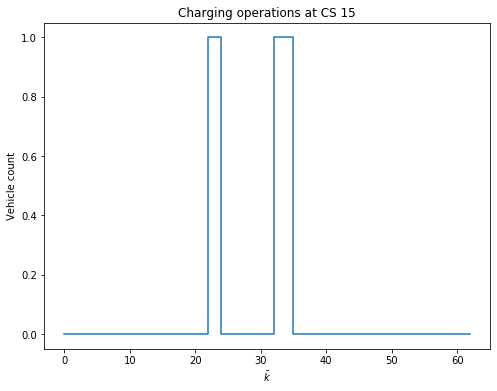

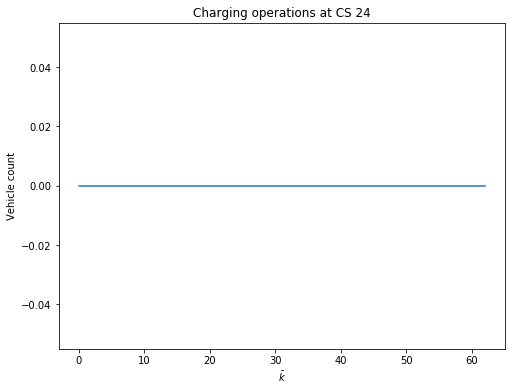

In [16]:
# %% Vehicles dynamics

# Vectors to plot

colorArrowTravel = 'SteelBlue'
colorArrowCharging = 'Crimson'
colorArrowServing = 'SeaGreen'

# Plot
maxTw = -1
minTw = 100000000000
for vehicleID, vehicle in vehiclesDict.items():
    # figures
    figX1 = figure(plot_width=600, plot_height=450,
                   title='Time the (vehicle '+str(vehicleID)+')',
                   toolbar_location='right')
    figX2 = figure(plot_width=600, plot_height=450,
                   title='SOC (vehicle '+str(vehicleID)+')',
                  y_range=(0, 100),
                  toolbar_location=None)
    figX3 = figure(plot_width=600, plot_height=450,
                   title='Payload (vehicle '+str(vehicleID)+')',
                  toolbar_location=None)
    
    # reaching leaving states for the vehicle
    reachingLeavingStates = leavingReachingSequences[vehicleID]

    # time windows
    nSeq = vehicle.nodeSequence
    kCustomers = []
    tWindowsUpper = []
    tWindowsLower = []
    for i, node in enumerate(nSeq):
        if networkDict[node].isCustomer():
            kCustomers.append(i)
            tWindowsCenter = (networkDict[node].timeWindowUp + networkDict[node].timeWindowDown) / 2.0
            tWindowsWidth =(networkDict[node].timeWindowUp - networkDict[node].timeWindowDown) / 2.0
            tWindowsUpper.append(tWindowsCenter + tWindowsWidth)
            tWindowsLower.append(tWindowsCenter - tWindowsWidth)
            # Time windows whiskers
            whiskerTW = Whisker(base=i, upper=tWindowsCenter + tWindowsWidth, lower=tWindowsCenter - tWindowsWidth)
            figX1.add_layout(whiskerTW)
            
            # update TW bounds
            if tWindowsCenter + tWindowsWidth > maxTw:
                maxTw = tWindowsCenter + tWindowsWidth
            if tWindowsCenter - tWindowsWidth < minTw:
                minTw = tWindowsCenter - tWindowsWidth
    
    # adjust fig 1 to fit TWs
    figX1.y_range=Range1d(minTw-10, maxTw+10)

    kVehicle = range(0, vehicle.si)

    figX1.line(kVehicle, reachingLeavingStates[0, :], alpha=0)
    figX1.line(kVehicle, reachingLeavingStates[1, :], alpha=0)
    figX2.line(kVehicle, reachingLeavingStates[2, :], alpha=0)
    figX2.line(kVehicle, reachingLeavingStates[3, :], alpha=0)
    figX3.line(kVehicle, reachingLeavingStates[4, :], alpha=0)

    reachingLeavingVectorPrev = reachingLeavingStates[:, 0]
    nodePrev = nSeq[0]
    kPrev = 0

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[0], y_offset=-5, text=str(node), text_baseline='top')
    figX1.add_layout(label)

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[2], y_offset=-5, text=str(node), text_baseline='top')
    figX2.add_layout(label)

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[4], y_offset=-5, text=str(node), text_baseline='top')
    figX3.add_layout(label)
    
    # Axes
    figX1.xaxis.axis_label = 'k'
    figX1.yaxis.axis_label = 'Time of the day (min)'
    figX1.axis.axis_label_text_font_size = '15pt'
    figX1.axis.major_label_text_font_size = '13pt'
    figX1.title.text_font_size = '15pt'
    
    figX2.xaxis.axis_label = 'k'
    figX2.yaxis.axis_label = 'SOC (%)'
    figX2.axis.axis_label_text_font_size = '15pt'
    figX2.axis.major_label_text_font_size = '13pt'
    figX2.title.text_font_size = '15pt'
    
    figX3.xaxis.axis_label = 'k'
    figX3.yaxis.axis_label = 'Payload (ton)'
    figX3.axis.axis_label_text_font_size = '15pt'
    figX3.axis.major_label_text_font_size = '13pt'
    figX3.title.text_font_size = '15pt'
    
    # horizontal line SOC
    hline1 = Span(location=40, dimension='width', line_color='black')
    hline2 = Span(location=80, dimension='width', line_color='black')
    figX2.renderers.extend([hline1, hline2])
    
    
    for reachingLeavingVector, node, k in zip(reachingLeavingStates[:, 1:].T, nSeq[1:], range(1, vehicle.si)):
        # x1
        label = Label(x=k, y=reachingLeavingVector[0], y_offset=-5, text=str(node), text_baseline='top')
        figX1.add_layout(label)

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[1],
                            x_end=k, y_end=reachingLeavingVector[0],
                            end=VeeHead(size=8, fill_color=colorArrowTravel, line_color=colorArrowTravel),
                            line_color=colorArrowTravel, line_alpha=1)

        if networkDict[node].isChargeStation():
            colorArrowSpent = colorArrowCharging
        else:
            colorArrowSpent = colorArrowServing

        arrowSpent = Arrow(x_start=k, y_start=reachingLeavingVector[0],
                           x_end=k, y_end=reachingLeavingVector[1],
                           end=VeeHead(size=8, fill_color=colorArrowSpent, line_color=colorArrowSpent),
                           line_color=colorArrowSpent, line_alpha=1)

        figX1.add_layout(arrowTravel)
        figX1.add_layout(arrowSpent)

        # x2
        label = Label(x=k, y=reachingLeavingVector[3], y_offset=10, text=str(node), text_baseline='top')
        figX2.add_layout(label)

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[3],
                            x_end=k, y_end=reachingLeavingVector[2],
                            end=VeeHead(size=8, fill_color=colorArrowTravel, line_color=colorArrowTravel),
                            line_color=colorArrowTravel, line_alpha=1, line_width=1.5, visible=True)
        figX2.add_layout(arrowTravel)

        if networkDict[node].isChargeStation():
            colorArrowSpent = colorArrowCharging
            arrowSpent = Arrow(x_start=k, y_start=reachingLeavingVector[2],
                               x_end=k, y_end=reachingLeavingVector[3],
                               end=VeeHead(size=8, fill_color=colorArrowSpent, line_color=colorArrowSpent),
                               line_color=colorArrowSpent, line_alpha=1, line_width=1.5, visible=True)
            figX2.add_layout(arrowSpent)


        # x3
        label = Label(x=k, y=reachingLeavingVector[4], y_offset=-5, text=str(node), text_baseline='top')
        figX3.add_layout(label)

        if networkDict[nodePrev].isChargeStation():
            colorArrow = colorArrowCharging

        else:
            colorArrow = colorArrowTravel

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[4],
                            x_end=k, y_end=reachingLeavingVector[4],
                            end=VeeHead(size=8, fill_color=colorArrow, line_color=colorArrow),
                            line_color=colorArrow, line_alpha=1, line_width=1.5, visible=True)
        figX3.add_layout(arrowTravel)

        # common
        reachingLeavingVectorPrev = reachingLeavingVector
        nodePrev = node
        kPrev = k
        
    # Save
    export_png(figX1, filename=figureFolderPath+"x1_vehicle"+str(vehicleID)+".png")
    
    export_png(figX2, filename=figureFolderPath+"x2_vehicle"+str(vehicleID)+".png")
    
    export_png(figX3, filename=figureFolderPath+"x3_vehicle"+str(vehicleID)+".png")   
    
    
    # Show
    show(figX1)
    show(figX2)
    show(figX3)

# %% Plot results for CSs
for cs in networkDict['CS_LIST']:
    fig = plt.figure(figsize=(8, 6))
    csID = cs.id
    counter = thetaMatrix[csID, :]
    plt.step(np.arange(len(counter)), counter)
    plt.title('Charging operations at CS ' + str(csID))
    plt.xlabel(r'$\bar{k}$')
    plt.ylabel('Vehicle count')
    plt.savefig(figureFolderPath+"CS_"+str(cs.id)+".png")
    plt.show()


In [14]:
# %% Time of execution
tEnd = time.time()
print("Total execution time:", (tEnd - t0) * 1000.0, "ms")

Total execution time: 52355.82685470581 ms
